# Auto Insurance Claim Fraud Detection

## 1. Business Understanding
## 2. Data Overview
## 3. Exploratory Data Analysis (EDA)
## 4. Data Preprocessing
## 5. Feature Engineering
## 6. Modeling
## 7. Evaluation
## 8. Explainability
## 9. Business Insights
## 10. Limitations & Next Steps


### Business Context
Insurance companies process large volumes of claims, but only a small fraction can be investigated for potential fraud due to limited Special Investigations Unit (SIU) capacity. Fraudulent claims increase loss ratios and operating costs, while excessive investigations can harm customer trust and increase expenses.

### Objective
Using information available at claim time, build an interpretable fraud risk scoring model that helps prioritize claims for investigation. The model should support decision-making under capacity constraints rather than aiming to label claims as definitively fraudulent.


In [1]:

# DATA HANDLING

import pandas as pd           
import numpy as np             


# VISUALIZATION

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Loading the dataset

df = pd.read_csv("../data/fraud_oracle.csv")

#quick dattaset preview
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [4]:
#checking dataset shape

df.shape


(15420, 33)

In [5]:
# Columns overview

df.columns


Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [7]:
# Check target column distribution
df['FraudFound_P'].value_counts()


FraudFound_P
0    14497
1      923
Name: count, dtype: int64

In [8]:
# Check missing values (just top 10)
df.isna().sum().sort_values(ascending=False).head(10)


Month                 0
WeekOfMonth           0
DayOfWeek             0
Make                  0
AccidentArea          0
DayOfWeekClaimed      0
MonthClaimed          0
WeekOfMonthClaimed    0
Sex                   0
MaritalStatus         0
dtype: int64

## Trying to understand the dataset in a business focused manner

The goal is to identify which columns are **safe to use at claim intake** and which may cause **post-claim leakage**.  

We also categorize features into:
- Numeric
- Categorical
- Binary
- IDs

This will be summarized in a **professional table** to guide feature engineering.



In [14]:

# Columns in dataset
columns = df.columns.tolist()

# Safe at intake columns (I assumed based on educational study and reasoning)
safe_at_intake = [
    "Month","WeekOfMonth","DayOfWeek","Make","AccidentArea",
    "Sex","MaritalStatus","Age","PolicyType","VehicleCategory",
    "VehiclePrice","PolicyNumber","RepNumber","Deductible",
    "DriverRating","Days_Policy_Accident","Days_Policy_Claim",
    "PastNumberOfClaims","AgeOfVehicle","AgeOfPolicyHolder",
    "AgentType","NumberOfSuppliments","AddressChange_Claim",
    "NumberOfCars","Year","BasePolicy"
]

# Feature type based on business logic
feature_types = []
for col in columns:
    if col in ["PolicyNumber","RepNumber"]:
        feature_types.append("ID")
    elif col in ["Fault","PoliceReportFiled","WitnessPresent","FraudFound_P"]:
        feature_types.append("Binary")
    elif col in ["Month","WeekOfMonth","DayOfWeek","DayOfWeekClaimed",
                 "MonthClaimed","WeekOfMonthClaimed","Age","VehiclePrice",
                 "Deductible","DriverRating","Days_Policy_Accident",
                 "Days_Policy_Claim","PastNumberOfClaims","AgeOfVehicle",
                 "AgeOfPolicyHolder","NumberOfSuppliments","AddressChange_Claim",
                 "NumberOfCars","Year"]:
        feature_types.append("Numeric")
    else:
        feature_types.append("Categorical")

# Creating summary table
feature_summary = pd.DataFrame({
    "Column": columns,
    "Data_Type": [str(df[col].dtype) for col in columns],
    "Safe_At_Intake": ["Yes" if col in safe_at_intake else "No" for col in columns],
    "Feature_Type": feature_types,
    "Notes": ["" for _ in columns]
})

feature_summary


,Column,Data_Type,Safe_At_Intake,Feature_Type,Notes
0,Month,object,Yes,Numeric,
1,WeekOfMonth,int64,Yes,Numeric,
2,DayOfWeek,object,Yes,Numeric,
3,Make,object,Yes,Categorical,
4,AccidentArea,object,Yes,Categorical,
5,DayOfWeekClaimed,object,No,Numeric,
6,MonthClaimed,object,No,Numeric,
7,WeekOfMonthClaimed,int64,No,Numeric,
8,Sex,object,Yes,Categorical,
9,MaritalStatus,object,Yes,Categorical,


## Exploratory Data Analysis (EDA) & Missing Values

At this stage, I will analyze features that are **safe at claim intake**:

1. Check for missing values and decide how to handle them.
2. Understand feature distributions (numeric, categorical, binary).
3. Identify class imbalance in the target variable.
4. Generate initial visualizations to highlight patterns for modeling.

> i will Only be using features marked as **Safe_At_Intake = Yes**.


In [17]:
safe_features = feature_summary[
    (feature_summary['Safe_At_Intake'] == 'yes') &
    (feature_summary ['Feature_Type'].isin(['ID']))
]['Column'].tolist()

#subset dataset
df_safe = df[safe_features + ['FraudFound_P']]

# Check missing values
missing_summary = df_safe.isnull().sum().sort_values(ascending=False)
missing_percent = (df_safe.isnull().mean()*100).sort_values(ascending=False)

missing_table = pd.DataFrame({
    "Missing_Count": missing_summary,
    "missing_percent": missing_percent
})

missing_table

,Missing_Count,missing_percent
FraudFound_P,0,0.0


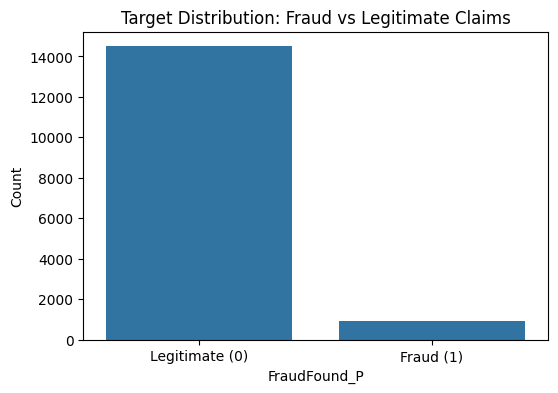

In [18]:
# Target counts
plt.figure(figsize=(6,4))
sns.countplot(data=df_safe, x='FraudFound_P')
plt.title("Target Distribution: Fraud vs Legitimate Claims")
plt.xlabel("FraudFound_P")
plt.ylabel("Count")
plt.xticks([0,1], ["Legitimate (0)", "Fraud (1)"])
plt.show()